In [7]:
#Import libraries
import nltk, re
import numpy as np 
import pandas as pd 
from nltk.corpus import stopwords
import string

In [8]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/messages.csv')
df.head(5)

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [9]:
df.shape

(2893, 3)

In [10]:
df.columns

Index(['subject', 'message', 'label'], dtype='object')

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.shape

(2876, 3)

In [13]:
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [14]:
df=df.replace(np.nan,"",regex=True)
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [15]:
df.isnull().sum()

subject    0
message    0
label      0
dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


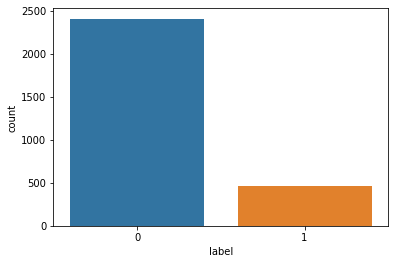

In [16]:
import seaborn as sns
sns.countplot(x=df['label'])

In [17]:
df['mail']= df["subject"].astype(str) +" "+ df["message"]
df.head()

,subject,message,label,mail
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...
1,,"lang classification grimes , joseph e . and ba...",0,"lang classification grimes , joseph e . and b..."
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...


In [18]:
df.drop(['subject','message'],axis=1,inplace=True)

In [19]:
def lower_case(series):
    return series.lower()

In [20]:
df['mail']=df['mail'].apply(lower_case)

In [21]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-_*0-9+]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
def text_prepare(series):
    series=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$','email',series)
    series=re.sub(r'^http\://[a-z0-9\-\.]+\.[a-z]{2,3}(/\S*)?$','webaddress',series)
    series=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','number',series)
    series=re.sub(r'\d+(\.\d+)?', 'numbr',series)
    series=re.sub(REPLACE_BY_SPACE_RE," ",series)
    series = re.sub(BAD_SYMBOLS_RE," ",series)
    series = re.sub(r'\s+'," ",series)
    return series

In [22]:
df['mail']=df['mail'].map(text_prepare)
df

,label,mail
0,0,job posting apple iss research center content ...
1,0,lang classification grimes joseph e and barba...
2,0,query letter frequencies for text identificati...
3,0,risk a colleague and i are researching the dif...
4,0,request book information earlier this morning ...
...,...,...
2888,1,love your profile ysuolvpv hello thanks for st...
2889,1,you have been asked to join kiddin the list ow...
2890,0,anglicization of composers names judging from ...
2891,0,re numbr numbr comparative method n ary compar...


In [25]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['mail'] = df['mail'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


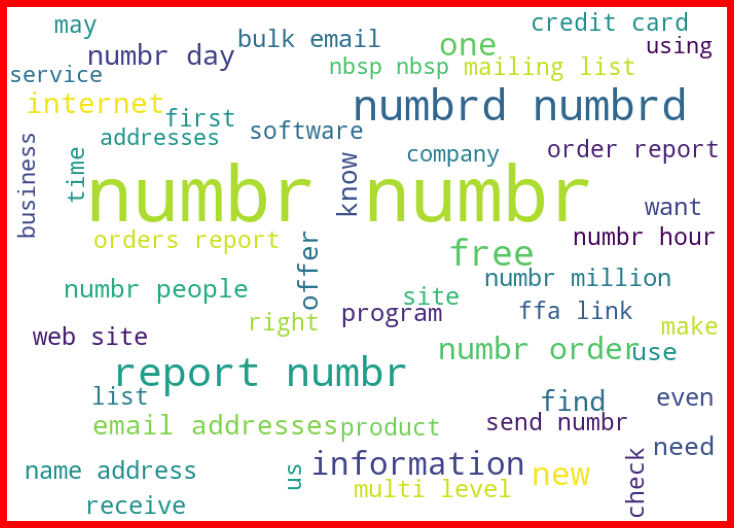

In [27]:
#Getting sense of loud words in spam 
import matplotlib.pyplot as plt

from wordcloud import WordCloud


spams = df['mail'][df['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

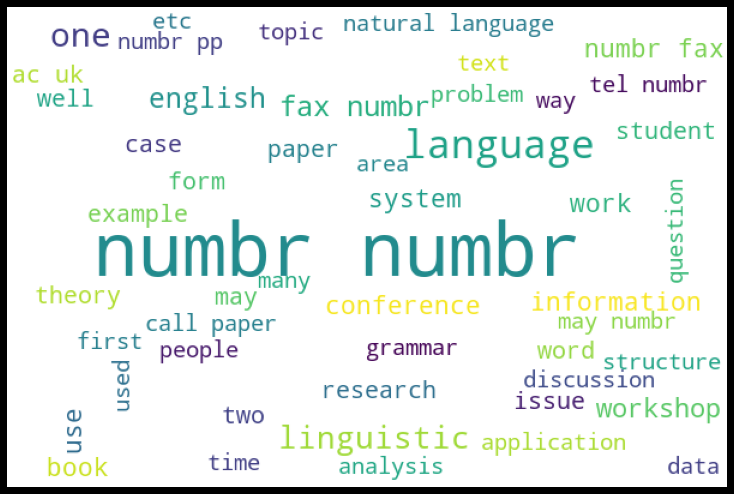

In [28]:
hams = df['mail'][df['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,log_loss

tf_vec = TfidfVectorizer()

naive = MultinomialNB()

features = tf_vec.fit_transform(df['mail'])

X = features
y = df['label']

In [30]:
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test=train_test_split(X,y,train_size=0.7)

In [34]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler(0.70)
X_train_ns,Y_train_ns=os.fit_sample(X_train,Y_train)
print("The number of classes before fit {}".format(Counter(Y_train)))
print("The number of classes after fit {}".format(Counter(Y_train_ns)))

The number of classes before fit Counter({0: 1691, 1: 322})
The number of classes after fit Counter({0: 1691, 1: 1183})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
naive.fit(X_train_ns,Y_train_ns)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9942062572421785


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       717
           1       0.99      0.98      0.98       146

    accuracy                           0.99       863
   macro avg       0.99      0.99      0.99       863
weighted avg       0.99      0.99      0.99       863



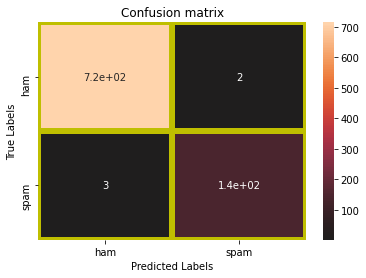

In [38]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='y',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()

In [39]:
conf_mat


array([[715,   2],
       [  3, 143]])

In [40]:
log=log_loss(y_test,y_pred)

In [41]:
print(log)

0.20011063866676085


In [43]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(naive) 
  
# Load the pickled model 
naive_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
naive_from_pickle.predict(x_test)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [44]:
from sklearn.externals import joblib
joblib.dump(naive,"spam_email.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['spam_email.pkl']